# Project: Medical Appointment No-shows Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#limitations">Limitations</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

>This report examines a dataset of 100,000 medical appointments in Brazil. 
In particular, we will examine the relationships between **failing to show up for a medical appointment** and several patient factors.We will explore and answer the following questions:
+ How does receiving an SMS message prior to the appointment relate to a patient being a no-show? 
+ What is the relationship between enrollment in the Bolsa Familia social welfare program and being a no-show? 
+ In which neighborhoods do patients miss their medical appointments most frequently? 
+ How do patient age and missed medical appointments relate? 

## Motivation
Missed medical appointments are a costly problem for healthcare systems, and understanding patient factors related to missed appointments can help healthcare systems identify potential solutions to this problem.

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

<a id='wrangling'></a>
## Data Wrangling

In [2]:
# load the dataset
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

The Patient ID was originally formatted as a float, but it should be an integer since it's just a label. 

In [3]:
# change PatientID to integer
# I consulted the linked resource: 
# https://stackoverflow.com/questions/33034559/how-to-remove-last-the-two-digits-in-a-column-that-is-of-integer-type 
df['PatientId'] = df['PatientId'].astype(np.int64).astype(str).str[:-2].astype(np.int64)

In [4]:
# Make sure we fixed the Patient ID
df.head(2)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,298724998242,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5589977766944,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No


In [5]:
# inspect the dataset for missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null int64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: int64(9), object(5)
memory usage: 11.8+ MB


It looks like there aren't any missing values.

Since we are not going to investigate anything regarding Gender, Scheduled Day, Appointment Day, Hypertension, Diabetes, Alcoholism, or Handicap, we will drop those columns from our dataset.

In [6]:
# drop the unnecessary colums and then verify we successfully dropped them from the dataset 
df.drop(['Gender', 'ScheduledDay', 'AppointmentDay', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap'], axis=1, inplace=True)

### Data Cleaning
#### Encode no-show as a dummy variable and ensure the other variables are ready to use

First, we get a summary of the data to assess if the values make sense to see what needs to be cleaned.

In [7]:
# summarize the data
df.describe()

,PatientId,AppointmentID,Age,Scholarship,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000
mean,1.474963e+12,5.675305e+06,37.088874,0.098266,0.321026
std,2.560949e+12,7.129575e+04,23.110205,0.297675,0.466873
min,3.920000e+02,5.030230e+06,-1.000000,0.000000,0.000000
25%,4.172614e+10,5.640286e+06,18.000000,0.000000,0.000000
50%,3.173184e+11,5.680573e+06,37.000000,0.000000,0.000000
75%,9.439172e+11,5.725524e+06,55.000000,0.000000,1.000000
max,9.999816e+12,5.790484e+06,115.000000,1.000000,1.000000


+ The Neighborhood column isn't represented here since the data is in string format, but we already saw that it doesn't have any missing values.  
+ The Patient ID and Appointment ID columns look fine.  
+ The Age column does have two items worth noting. First, the max age is 115 years old, which seems pretty old. However, the linked resource below shows some people do live to be 115, including a person from Brazil who lived around the time the dataset was collected. So, we will leave that data point untouched. The minimum recorded age is -1. This is not a possible age. Maybe this is referring to a medical appointment for a pregnant woman with an unborn child? Indeed, the dataset creator verified this in the Kaggle discussion forum for the dataset, which is linked below. So, we don't need to change any values in the Age column.  
+ Scholarship and SMS_received are both binary variables and their statistics show that there aren't any problems.
+ We saw in the output from df.info() that No-show is formatted as a string. We need to convert it to a dummy variable.

https://en.wikipedia.org/wiki/List_of_the_verified_oldest_people  
https://www.kaggle.com/joniarroba/noshowappointments/version/4/discussion/41457 

In [8]:
# convert No-show to a dummy variable
df['No_show'] = pd.get_dummies(df['No-show'], drop_first=True, dtype=int)
# I consulted the linked resource: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html

# drop the original No-show column
df.drop('No-show', axis=1, inplace=True)
# Check that we successfully encoded, dropped, and added
df.head(2)

,PatientId,AppointmentID,Age,Neighbourhood,Scholarship,SMS_received,No_show
0,298724998242,5642903,62,JARDIM DA PENHA,0,0,0
1,5589977766944,5642503,56,JARDIM DA PENHA,0,0,0


As a final check, we examime the Neighborhood column for any potential issues. 

In [9]:
df['Neighbourhood'].unique()

array(['JARDIM DA PENHA', 'MATA DA PRAIA', 'PONTAL DE CAMBURI',
       'REPÚBLICA', 'GOIABEIRAS', 'ANDORINHAS', 'CONQUISTA',
       'NOVA PALESTINA', 'DA PENHA', 'TABUAZEIRO', 'BENTO FERREIRA',
       'SÃO PEDRO', 'SANTA MARTHA', 'SÃO CRISTÓVÃO', 'MARUÍPE',
       'GRANDE VITÓRIA', 'SÃO BENEDITO', 'ILHA DAS CAIEIRAS',
       'SANTO ANDRÉ', 'SOLON BORGES', 'BONFIM', 'JARDIM CAMBURI',
       'MARIA ORTIZ', 'JABOUR', 'ANTÔNIO HONÓRIO', 'RESISTÊNCIA',
       'ILHA DE SANTA MARIA', 'JUCUTUQUARA', 'MONTE BELO',
       'MÁRIO CYPRESTE', 'SANTO ANTÔNIO', 'BELA VISTA', 'PRAIA DO SUÁ',
       'SANTA HELENA', 'ITARARÉ', 'INHANGUETÁ', 'UNIVERSITÁRIO',
       'SÃO JOSÉ', 'REDENÇÃO', 'SANTA CLARA', 'CENTRO', 'PARQUE MOSCOSO',
       'DO MOSCOSO', 'SANTOS DUMONT', 'CARATOÍRA', 'ARIOVALDO FAVALESSA',
       'ILHA DO FRADE', 'GURIGICA', 'JOANA D´ARC', 'CONSOLAÇÃO',
       'PRAIA DO CANTO', 'BOA VISTA', 'MORADA DE CAMBURI', 'SANTA LUÍZA',
       'SANTA LÚCIA', 'BARRO VERMELHO', 'ESTRELINHA', 'FORTE SÃO 

The data looks clean and ready to use!

<a id='eda'></a>
## Exploratory Data Analysis

Our goal is to determine what factors are related to not showing up for a medical appointment. 

### Exploring Data

As a first step, we create historgrams for each variable to get a quick overview of their distributions.

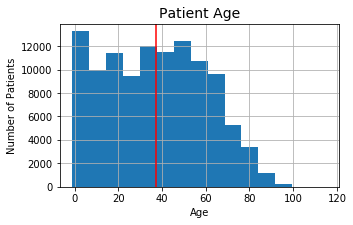

In [10]:
# create a histogram for Age with a line marking the average age 
# I consulted the linked resource: 
# https://stackoverflow.com/questions/16180946/drawing-average-line-in-histogram-matplotlib
df['Age'].hist(bins=15, figsize=(5,3))
plt.axvline(df['Age'].mean(), color='red')
plt.title('Patient Age', fontsize=14)
plt.xlabel('Age')
plt.ylabel('Number of Patients');

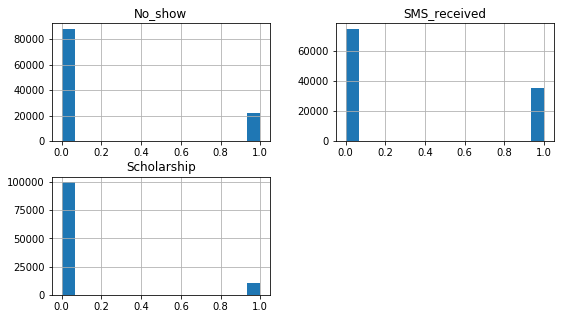

In [11]:
# create histograms for the other numeric variables
df[['SMS_received', 'Scholarship', 'No_show']].hist(bins=15, figsize=(9,5));

The histograms make it easy to see:
+ The age of patients is right skewed. That is, 50% of the patients are under the age of 40, but the range of ages is 116 years. 
+ There are far fewer no-shows than "shows," which is when a patient <i>is</i> present for their appointment.
+ Far fewer patients received SMS messages than did not receive SMS messages.
+ Far few patients received the Bolsa Familia scholarship than did not.

In [12]:
# create subsets of patients who showed up for their appointments and those who did not
no_shows = df.No_show == True
shows = df.No_show == False

In [13]:
# calculate the proportion of overall no-shows
df.No_show.mean()

0.20193255946510807

In [14]:
# calculate the proportion of patients who received an SMS
df.SMS_received.mean()

0.32102563174608917

### Age vs. No-show

In [15]:
# calculating the average age of patients that showed up and those that did not
df.Age[no_shows].mean(), df.Age[shows].mean()

(34.31766656212196, 37.790064393252315)

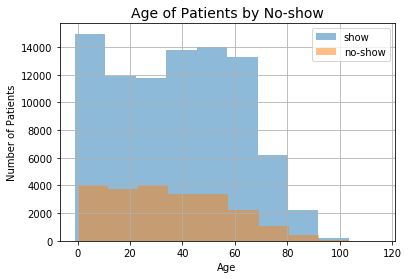

In [16]:
# create a histogram of the ages of patients who showed up and those who did not
df.Age[shows].hist(alpha=0.5, label='show')
df.Age[no_shows].hist(alpha=0.5, label='no-show')
plt.legend()
plt.title('Age of Patients by No-show', fontsize=14)
plt.xlabel('Age')
plt.ylabel('Number of Patients');

### SMS Received vs. No-show

In [17]:
# create susbsets of patients who received a SMS message and those who did not
SMS_yes = df.SMS_received == True
SMS_no = df.SMS_received == False

In [18]:
# calculate the proportion of patients who did not show up for their medical appoints for the SMS subsets
df.No_show[SMS_yes].mean(), df.No_show[SMS_no].mean()

(0.27574544839637, 0.16703311346525418)

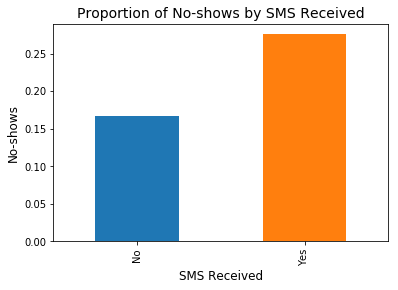

In [19]:
# create a bar chart to show the difference in proportions of No-shows for SMS subsets 
# I consulted the linked resource: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.xticks.html 
df.groupby('SMS_received').No_show.mean().plot.bar()
plt.title('Proportion of No-shows by SMS Received', fontsize=14)
plt.xlabel('SMS Received', fontsize=12)
plt.ylabel('No-shows', fontsize=12)
plt.xticks(np.arange(2),('No', 'Yes'));

This is an surprising result! Patients who received an SMS message showed up for the medical appointments 10.9% less of the time.

### Neighborhood vs. No-show

In [20]:
# calculate the proportion of no-shows for each neighborhood
# I consulted the linked resource: 
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html 
df.groupby('Neighbourhood').No_show.mean().sort_values(ascending=False)

Neighbourhood
ILHAS OCEÂNICAS DE TRINDADE    1.000000
SANTOS DUMONT                  0.289185
SANTA CECÍLIA                  0.274554
SANTA CLARA                    0.264822
ITARARÉ                        0.262664
JESUS DE NAZARETH              0.243954
HORTO                          0.240000
ILHA DO PRÍNCIPE               0.234775
CARATOÍRA                      0.230409
ANDORINHAS                     0.230327
PRAIA DO SUÁ                   0.228261
GURIGICA                       0.225966
BENTO FERREIRA                 0.224942
PARQUE MOSCOSO                 0.223192
MARUÍPE                        0.222923
DO MOSCOSO                     0.222760
ENSEADA DO SUÁ                 0.221277
ARIOVALDO FAVALESSA            0.219858
ILHA DAS CAIEIRAS              0.219421
FONTE GRANDE                   0.218475
CRUZAMENTO                     0.217454
SÃO JOSÉ                       0.216490
BARRO VERMELHO                 0.215130
NAZARETH                       0.214815
ROMÃO                     

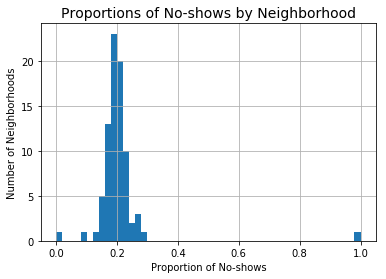

In [21]:
# create a histogram of the number neighborhoods by proportion of no-shows
df.groupby('Neighbourhood').No_show.mean().hist(bins=50)
plt.title('Proportions of No-shows by Neighborhood', fontsize=14)
plt.xlabel('Proportion of No-shows')
plt.ylabel('Number of Neighborhoods');

The histogram makes it easy to see that all neighborhoods but one have no-show rates less than or equal to 30%. Creating an ascending list of the patient counts by neighborhood lets us look more into the neighhborhoods with 100% no-show rates.

In [22]:
# create the ascending list of patient counts by neighborhood
# I consulted the linked resource: 
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html 
df['Neighbourhood'].value_counts(ascending=True)

PARQUE INDUSTRIAL                 1
ILHAS OCEÂNICAS DE TRINDADE       2
AEROPORTO                         8
ILHA DO FRADE                    10
ILHA DO BOI                      35
PONTAL DE CAMBURI                69
MORADA DE CAMBURI                96
NAZARETH                        135
SEGURANÇA DO LAR                145
UNIVERSITÁRIO                   152
HORTO                           175
SANTA HELENA                    178
ENSEADA DO SUÁ                  235
FRADINHOS                       258
ANTÔNIO HONÓRIO                 271
ARIOVALDO FAVALESSA             282
DE LOURDES                      305
COMDUSA                         310
BOA VISTA                       312
MÁRIO CYPRESTE                  371
DO MOSCOSO                      413
BARRO VERMELHO                  423
SANTA LUÍZA                     428
SANTA LÚCIA                     438
SANTA CECÍLIA                   448
PIEDADE                         452
SOLON BORGES                    469
SANTA CLARA                 

And sure enough, we see that ILHAS OCEÂNICAS DE TRINDADE only has 2 patients in the dataset, so it wasn't hard for 100% of patients in that neighborhood to miss their appointments. 

### Scholarship vs. No-show

We want to know if people who receive the Bolsa Familia scholarship fail to show up for medical appointments more or less than those who do not receive the scholarship.

In [23]:
# create susbsets of patients who received the Bolsa Familia scholarship and those who do not
Scholarship_yes = df.Scholarship == True
Scholarship_no = df.Scholarship == False

In [24]:
# calculate the proportion of no-shows for both subsets
df.No_show[Scholarship_yes].mean(), df.No_show[Scholarship_no].mean()

(0.2373630420771568, 0.19807155900708365)

Patients who receive the Bolsa Familia scholarship were no-shows 3.9% more often than patients who did not receive the scholarship. 

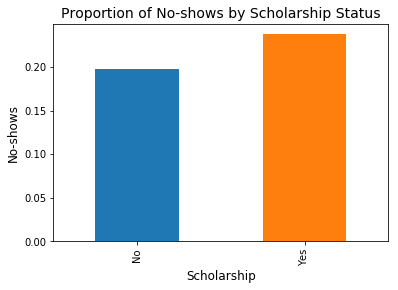

In [25]:
# create a bar chart to show the difference in proportions of No-shows for Scholarship subsets 
df.groupby('Scholarship').No_show.mean().plot.bar()
plt.title('Proportion of No-shows by Scholarship Status', fontsize=14)
plt.xlabel('Scholarship', fontsize=12)
plt.ylabel('No-shows', fontsize=12)
plt.xticks(np.arange(2),('No', 'Yes'));

<a id='limitations'></a>
## Limitations
While the dataset was generally clean and did not contain any missing values, there were a few steps that required some research to resolve. First, the Patient ID column was loaded as a float value in scientific notation. Since these values are just a label for each patient, it was necessary to change their data type to integers. This was required more steps and research time than I anticipated, but I learned some useful Python tricks along the way!

Additionally, the range of Age in the data required additional research to assess the validity of the extreme values. The data include patients with recorded ages of -1 years and 116 years. -1 years old is an impossible age and 116 years old seems highly unlikely. This situation was a helpful learning experience, because I was able to use resources external to the data to interpret these counterintuitive values. I found an explanation for the -1 years old data point in the discussion forums on Kaggle where the dataset was uploaded. The age of -1 referred to a pregnant woman having a medical appointment for her unborn child. I also found information regarding the oldest poeple who have lived, including a person who lived to be 116 in Brazil around the time the dataset was collected. 

<a id='conclusions'></a>
## Conclusions
Since we are not conducting any tests for statistical significance, the following conclusions only describe the *relationships* between the variables described. Additionally, these conclusions only describe the sample dataset, and make no claims regarding the population of Brazil as a whole. 

+ First, we found that 20.2% of the scheduled appointments in the sample resulted in no-shows.
+ We found the sample of patients was younger on average, with 50% of the patients under age 40, with an an age range of 116 years.
+ 32.1% of patients received an SMS message, but patients who received an SMS message were no-shows 10.9% more often than patients who did not receive an SMS message. 
+ The average age of no-show patients is 34.3 years old. The average age of patients who did show up for appointments is 37.8 years old. 
+ Excluding one neighborhood with only two patients sampled, the 5 neighborhoods with the highest no-show rates are:
     + Santos Dumont
     + Santa Cecilia
     + Santa Clara
     + Itarare
     + Jesus de Nazareth
+ Patients who receive the Bolsa Familia social welfare scholarship were no-shows 3.9% more often than patients who did not receive the scholarship